In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from scipy.stats.distributions import t as scp_t
import scipy.stats as sst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sqlalchemy import create_engine, Column, String, Integer, Boolean, MetaData, Table, case, between, ForeignKey
from sqlalchemy.orm import mapper, create_session, relationship
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.ext.automap import automap_base
import sqlalchemy.types as types
from sqlalchemy.sql import select, and_, or_, not_, func
from TPAR import PARfxns as pf, loadDataFRP as FRP
from TPAR import mplRC
%matplotlib inline

mpl default settings: fs=16, lw=1, ms=8


# Check profiles with transmissivity values >100 or <0
- develope QC criteria

In [29]:
# fxn to id stations where sensor returns >=4 consecutive identical values at some point during cast:
def hasconst(x):
    ans=False
    if len(x)>4:
        nodiff=[int(ii) for ii in (x[1:]-x[:-1])==0]
        il=slidingWindowEval(nodiff,np.nansum,3)>=3
        if np.sum(il)>0:
            ans=True
    return ans

In [2]:
amp=FRP.amp
slidingWindowEval=FRP.slidingWindowEval
# develop transmissivity QC function using turbQC approach as starting point
def xmissQC(x0,dz=1):
    # default assumes data is binned in ~1m intervals, as for STRATOGEM profiles
    x=np.array(x0)
    if len(x)>2:
        # eliminate areas with large derivatives alternating in sign:
        diff=x[1:]-x[:-1]
        diff[np.abs(diff)<5*dz]=0 # don't worry about derivatives smaller than 5%/m (expected noise)
        ind=[int(ii) for ii in np.concatenate(([0],diff[1:]*diff[:-1],[0]))<0] # 1 for local extremum
        ii1=slidingWindowEval(ind,np.nansum,3)>1 # len 3 window centered on point has at least 2 deriv sign changes
        # extend region eliminated by 1 on either size
        ii1[:-1]=ii1[:-1]|ii1[1:]
        ii1[1:]=ii1[1:]|ii1[:-1]
    else: 
        ii1=np.ones(x.shape).astype(bool)
    # remove areas with 4 or more identical values in a row:
    if len(x)>4:
        # eliminate areas with large derivatives alternating in sign:
        nodiff=[int(ii) for ii in (x[1:]-x[:-1])==0]
        il=slidingWindowEval(nodiff,np.nansum,3)>=3
        ii3=np.zeros(x.shape).astype(bool)
        ii3[:-1]=il
        ii3[1:]=ii3[1:]|il
        # extend 1 point beyond the no-change values on either side:
        numiter=0
        while numiter<2:
            ii3[:-1]=ii3[:-1]|ii3[1:]
            ii3[1:]=ii3[1:]|ii3[:-1]
            numiter+=1
    else:
        ii3=np.ones(x.shape).astype(bool)
        
    # negative and zero values will have to be removed because they cannot be converted to beam attenuation
    # in some cases instrument is returning constant negative values in periods where there is no other indication of high turbidity;
    # this appears to indicate instrument failure
    # some surrounding values also appear pulled toward zero, possibly due to intermittent malfunction before full failure?
    # - remove 2 points to either side of repeated negative values
    ii2=x<0
    numiter=0
    while numiter<2:
        ii2[:-1]=ii2[:-1]|ii2[1:]
        ii2[1:]=ii2[1:]|ii2[:-1]
        numiter+=1
    y=x
    y[np.logical_or.reduce((ii1,ii2,ii3))]=np.nan
    # remove too high values: 
    y[y>110]=np.nan
    ## first, filter out jumps of more than 15 units:
    #if len(x)>=3:
    #    ii1=slidingWindowEval(x,amp,3)>50
    #else:
    #    ii1=False*np.ones(np.shape(x))
    ##Values <=0 look like instrument error; also they cannot be converted to beam transmission (1/m)
    ## remove very low values and very high values (but not slightly high values)
    #ii2=(x<=0)|(x>120)
    #y=np.copy(x)
    #y[np.logical_or(ii1,ii2)]=np.nan   
    
    
    ## turbidity sensor produced erroneous zero readings interspersed with real data when too close to surface
    ## remove suspect values from analysis
    ## - median filter alone was not enough
    ## remove a point if the max-min of the surrounding 5 point window 
    ## is greater than 1/3 the maximum turbidity value of the cast 
    ## (remove data within 5 points of a large jump)
    ##ii1=amp(rolling_window_padded(x,5),-1)>.33*np.nanmax(x)
    #ii1=slidingWindowEval(x,amp,5)>.33*np.nanmax(x) # was .5
    ## remove data within 5 points of a near-zero turbidity value
    ##ii2=np.nanmin(rolling_window_padded(x,5),-1)<.3
    #ii2=slidingWindowEval(x,np.nanmin,5)<.3
    #y=np.copy(x)
    #y[np.logical_or(ii1,ii2,)]=np.nan
    #y=ssig.medfilt(y,3)
    return y 

### FRP data

In [3]:
df0, zCasts=FRP.loadDataFRP(exp='all',sel='wide',dp=1.0)

In [4]:
dfall=FRP.flattenCastsDict(zCasts)
dfall.rename(columns={'turb':'NTU'},inplace=True)
dfall['cx']=FRP.cXfromX(dfall['xmiss'])

In [5]:
print('min xmiss:',np.min(dfall['xmiss']),'\nmax xmiss:',np.max(dfall['xmiss']))

min xmiss: -0.018399999999999993 
max xmiss: 96.97598417570259


Profiles with negative values


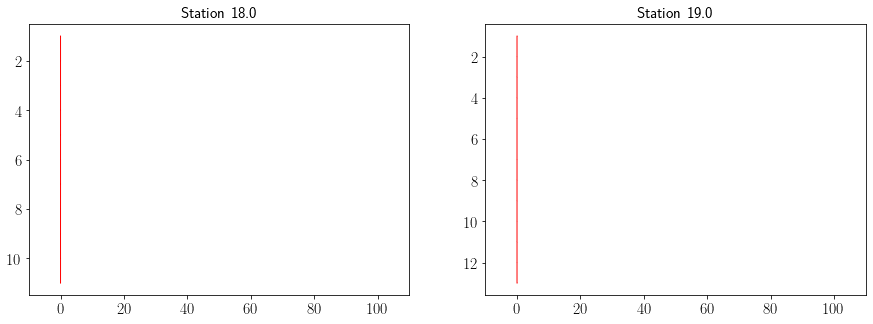

In [6]:
stalist=np.unique(dfall.loc[dfall.xmiss<0,['sta']])
fig,ax=plt.subplots(1,len(stalist),figsize=(15,5))
for ii, ista in enumerate(stalist):
    tdf=dfall.loc[dfall.sta==ista].sort_values('prSM')
    ax[ii].plot(tdf['xmiss'],tdf['prSM'],'r-')
    ax[ii].set_xlim(-.1,.1)
    ax[ii].invert_yaxis()
    ax[ii].set_title(f'Station {ista}')
    ax[ii].set_xlim(-10,110)
    x=tdf['xmiss'].values
    noderiv=(x[1:]-x[:-1])==0
    if np.sum(noderiv)>0:
        print(f'{ista} Consts?: {np.sum(noderiv)}')
print('Profiles with negative values')

#### These were stations in the Fraser with the highest turbidity and TSS observed. Leave them out of calculations involving transmissivity because there is not a clear way to extract meaningful information

#### ID stations with constant sections:

In [46]:
for ii, ic in enumerate(dfall.castid.values):
    tdf=dfall.loc[(dfall.castid==ic)]
    xm=tdf['xmiss'].values.flatten()
    if hasconst(xm):
        print(f'Sta: {np.unique(tdf.sta)}, cast: {ic}')

In [7]:
df0.loc[df0.ALS_Turb_NTU>=0,['Station','Date', 'SecchiDepth_m','ALS_Turb_NTU', 'ALS_TSS_mgL','sb19Turb_uncorrected','Sal']]

,Station,Date,SecchiDepth_m,ALS_Turb_NTU,ALS_TSS_mgL,sb19Turb_uncorrected,Sal
1,2.0,20170410,0.60,25.40,32.5,712.901615,0.268103
2,3.0,20170410,3.00,2.40,8.9,53.135185,25.965052
3,4.0,20170410,3.00,2.54,12.2,63.973250,25.503570
4,5.0,20170410,1.50,8.28,18.9,231.201766,17.205491
6,7.0,20170410,1.20,8.60,15.7,188.149816,18.348575
8,9.0,20170410,0.80,9.36,21.8,263.411919,12.390206
10,11.0,20170531,0.90,6.80,29.5,186.639895,17.583421
11,12.0,20170531,0.35,21.70,24.3,608.374941,6.651102
12,13.0,20170531,0.50,13.50,21.1,411.395455,11.710359
15,15.0,20170531,1.25,5.57,31.9,176.075826,13.366615


In [8]:
dfall.keys()

Index(['isup', 'sta', 'castid', 'prSM', 'gsw_ctA0', 'gsw_srA0', 'xmiss', 'par',
       'wetStar', 'sbeox0ML_L', 'seaTurbMtrnoQC', 'turb_uncor', 'NTU', 'cx'],
      dtype='object')

In [9]:
dfall.loc[dfall.sta==3]

,isup,sta,castid,prSM,gsw_ctA0,gsw_srA0,xmiss,par,wetStar,sbeox0ML_L,seaTurbMtrnoQC,turb_uncor,NTU,cx
24,1,3.0,5,1.0,8.591339,25.983465,69.174536,2.325239e+02,14.536400,7.305039,52.870801,52.738954,1.710018,1.474149
25,1,3.0,5,2.0,8.557910,26.414945,71.920417,1.316302e+02,15.681238,7.165835,47.652456,46.806962,1.517678,1.318440
26,1,3.0,5,3.0,8.522449,26.888488,76.383613,8.212882e+01,14.384032,6.900959,39.415372,38.962323,1.263322,1.077608
27,1,3.0,5,4.0,8.497187,27.079040,79.625276,4.971691e+01,9.798991,6.563529,34.355847,34.331376,1.113167,0.911354
28,1,3.0,5,5.0,8.477757,27.672911,85.190041,3.362590e+01,6.364046,6.185958,28.296127,27.396218,0.888300,0.641143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0,3.0,6,89.0,8.347322,29.907164,95.830424,1.000000e-12,1.269585,4.545906,5.099757,5.025939,0.162962,0.170360
206,0,3.0,6,90.0,8.326093,29.909628,95.962596,1.000000e-12,1.227719,4.575025,4.909972,4.930125,0.159855,0.164847
207,0,3.0,6,91.0,8.303073,29.913303,95.866263,1.000000e-12,1.213361,4.600238,4.983095,4.997040,0.162025,0.168864
208,0,3.0,6,92.0,8.282098,29.916303,95.862347,1.000000e-12,1.232754,4.624760,5.115614,5.183673,0.168076,0.169028


19.0 Consts?: 1
All downcasts


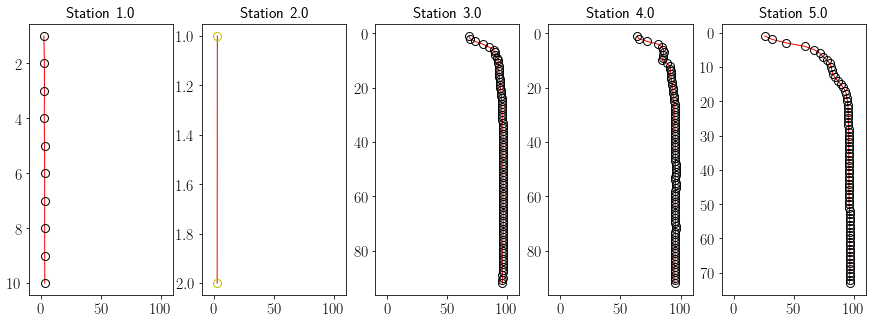

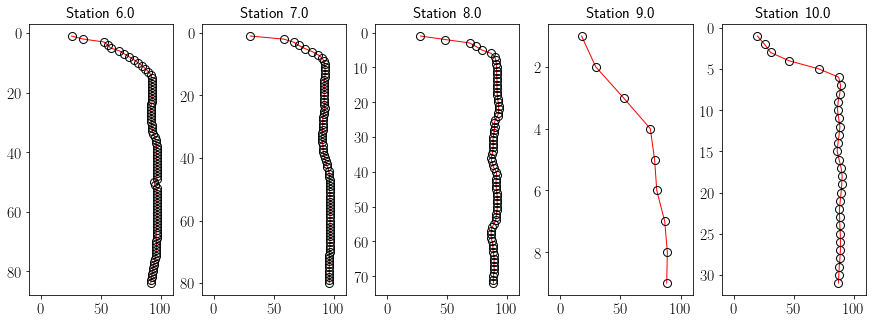

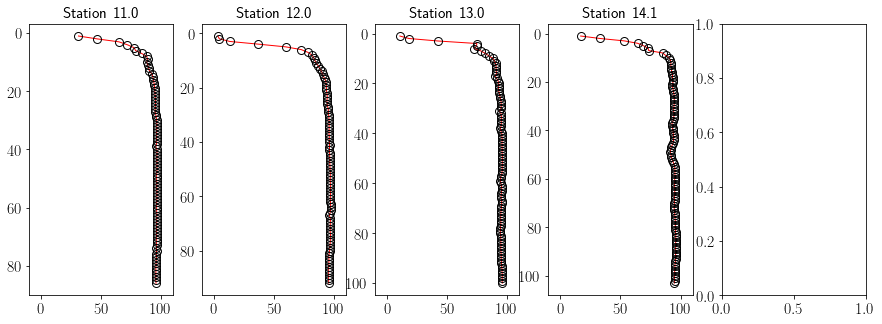

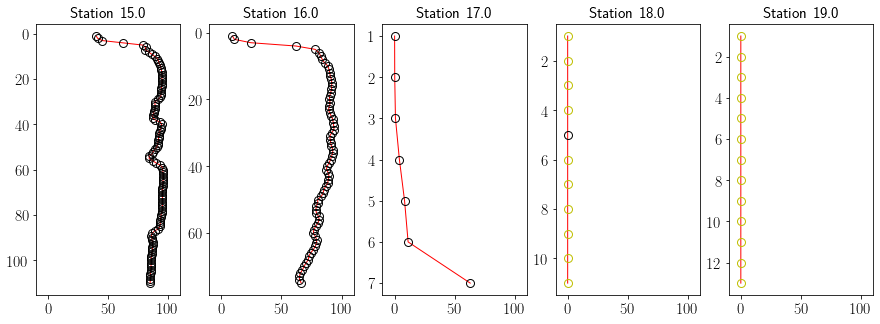

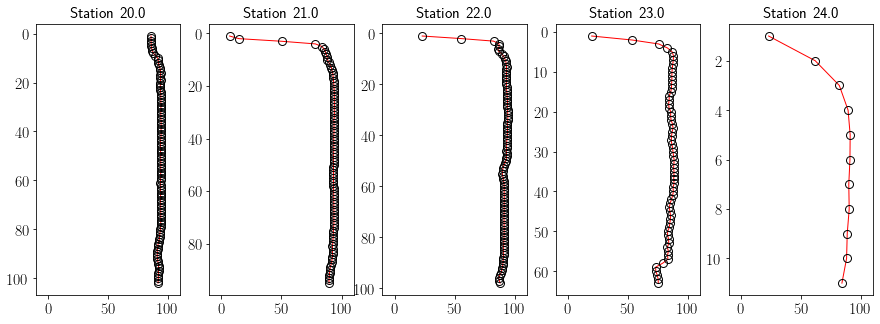

In [10]:
stalist=df0.Station
#for ii, ista in enumerate(stalist):
#    tdf=dfall.loc[dfall.sta==ista].sort_values('prSM')
#    ax[ii].plot(tdf['xmiss'],tdf['prSM'],'r-')
#    ax[ii].invert_yaxis()
#    ax[ii].set_title(f'Station {ista}')
for ii, ista in enumerate(stalist):
    if ii%5==0:
        fig,ax=plt.subplots(1,5,figsize=(15,5))
    tdf=dfall.loc[(dfall.sta==ista)&(dfall.isup==False)]
    if len(tdf)>0:
        xm=tdf['xmiss'].values.flatten()
        ax[ii%5].plot(xm,tdf['prSM'],'r-')
        ax[ii%5].plot(xm[xm>100],tdf.loc[xm>100,['prSM']],'c.',ms=5)
        ax[ii%5].plot(xmissQC(xm),tdf['prSM'],'o',markeredgecolor='k',markerfacecolor='None' )
        ix=np.isnan(xmissQC(xm))&~np.isnan(xm)
        ax[ii%5].plot(xm[ix],tdf.loc[ix,['prSM']],'o',markeredgecolor='y',markerfacecolor='None' )
        ax[ii%5].invert_yaxis()
        ax[ii%5].set_title(f'Station {ista}')
        ax[ii%5].set_xlim(-10,110)
        x=tdf['xmiss'].values
        noderiv=(x[1:]-x[:-1])==0
        if np.sum(noderiv)>0:
            print(f'{ista} Consts?: {np.sum(noderiv)}')
print('All downcasts')

In [11]:
dfall.loc[dfall.sta==17]

,isup,sta,castid,prSM,gsw_ctA0,gsw_srA0,xmiss,par,wetStar,sbeox0ML_L,seaTurbMtrnoQC,turb_uncor,NTU,cx
2236,1,17.0,35,1.0,12.688492,2.819606,0.112358,2.171193e+01,2.585380,7.322244,1456.795054,1454.594442,47.164037,27.164937
2237,1,17.0,35,2.0,12.254439,6.503691,0.317082,4.659958e-01,2.526218,7.009050,1231.070800,1232.225310,39.953900,23.015057
2238,1,17.0,35,3.0,11.852175,10.281001,0.749714,1.529375e-03,2.405258,6.679051,1003.445731,1004.226449,32.561223,19.572937
2239,1,17.0,35,4.0,11.357634,15.445185,3.298602,1.002766e-12,2.224992,6.228302,697.336187,696.851644,22.594846,13.646685
2240,1,17.0,35,5.0,11.159822,19.036282,7.130075,1.000000e-12,2.163814,5.919696,533.980313,534.740216,17.338515,10.563394
2241,1,17.0,35,6.0,11.574647,22.139574,38.465934,1.000000e-12,2.470090,5.822837,212.930824,213.337394,6.917291,3.821589
2242,1,17.0,35,7.0,11.478860,25.842218,73.284669,NaN,2.732065,5.855966,61.258391,60.961990,1.976643,1.243275
2243,0,17.0,36,1.0,12.755827,2.159982,0.094645,3.596399e+01,2.645656,7.304009,1465.569680,1462.483116,47.419821,27.851169
2244,0,17.0,36,2.0,12.293014,6.205263,0.190960,9.157839e-01,2.610891,6.926837,1290.807049,1288.928416,41.792452,25.043443
2245,0,17.0,36,3.0,11.819490,10.810748,0.789789,8.304792e-03,2.513145,6.536128,1070.257834,1076.640150,34.909178,19.364639


All upcasts


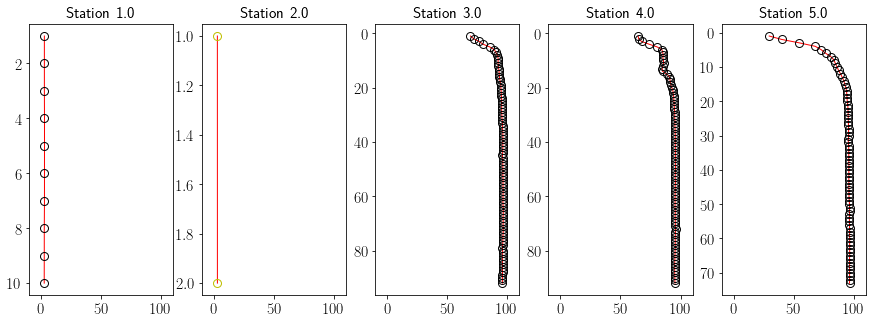

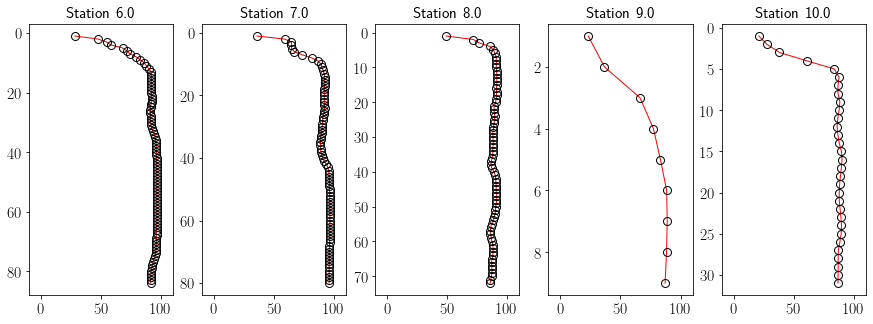

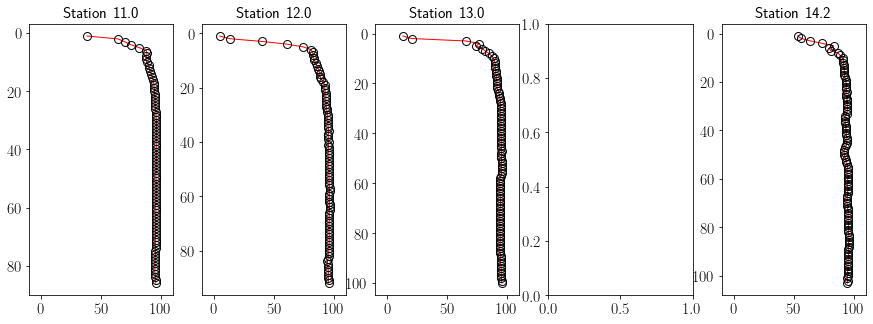

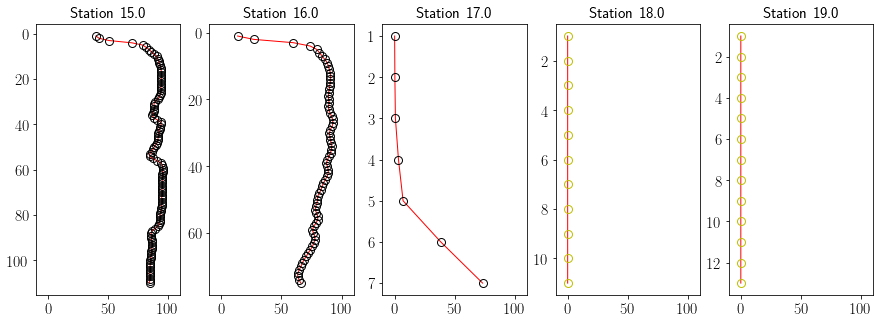

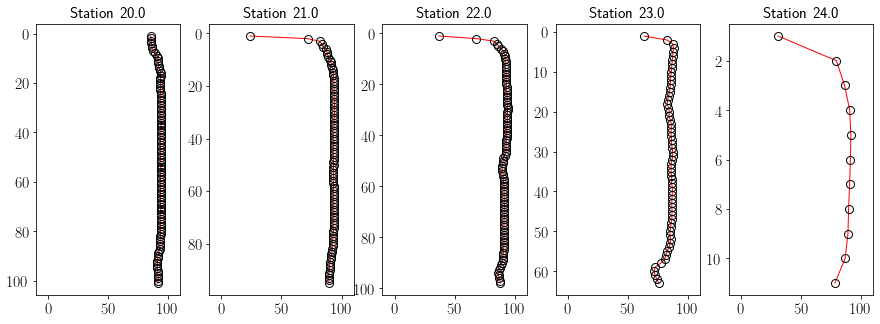

In [12]:
stalist=df0.Station
#for ii, ista in enumerate(stalist):
#    tdf=dfall.loc[dfall.sta==ista].sort_values('prSM')
#    ax[ii].plot(tdf['xmiss'],tdf['prSM'],'r-')
#    ax[ii].invert_yaxis()
#    ax[ii].set_title(f'Station {ista}')
for ii, ista in enumerate(stalist):
    if ii%5==0:
        fig,ax=plt.subplots(1,5,figsize=(15,5))
    tdf=dfall.loc[(dfall.sta==ista)&(dfall.isup==True)]
    if len(tdf)>0:
        xm=tdf['xmiss'].values.flatten()
        ax[ii%5].plot(xm,tdf['prSM'],'r-')
        ax[ii%5].plot(xmissQC(xm),tdf['prSM'],'o',markeredgecolor='k',markerfacecolor='None' )
        ax[ii%5].plot(xm[np.isnan(xmissQC(xm))],tdf.loc[np.isnan(xmissQC(xm)),['prSM']],'o',markeredgecolor='y',markerfacecolor='None' )
        ax[ii%5].invert_yaxis()
        ax[ii%5].set_title(f'Station {ista}')
        ax[ii%5].set_xlim(-10,110)
        x=tdf['xmiss'].values
        noderiv=(x[1:]-x[:-1])==0
        if np.sum(noderiv)>0:
            print(f'{ista} Consts?: {np.sum(noderiv)}')
print('All upcasts')

#### load STRATOGEM data:

In [13]:
basepath='/ocean/eolson/MEOPAR/obs/'
basedir=basepath + 'STRATOGEM/'
dbname='STRATOGEM'

Base = automap_base()
engine = create_engine('sqlite:///' + basedir + dbname + '.sqlite', echo = False)
# reflect the tables in salish.sqlite:
Base.prepare(engine, reflect=True)
# mapped classes have been created

CombStaTBL=Base.classes.CombStationTBL
CombProfTBL=Base.classes.CombProfTBL
CTDStationTBL=Base.classes.CTDStationTBL
CTDProfTBL=Base.classes.CTDProfTBL
session = create_session(bind = engine, autocommit = False, autoflush = True)
qbase=session.query(CTDProfTBL.CTDStationTBLID.label('StaID'),
                     CTDProfTBL.prSM,
                     CTDProfTBL.convertedDepth.label('Depth'),
                     CTDProfTBL.xmiss,
                     CTDProfTBL.wetStar,
                     CTDProfTBL.sal00,
                     CTDProfTBL.t090C,
                     CTDProfTBL.par).\
                filter(and_(
                     CTDProfTBL.CTDStationTBLID!=321,
                     CTDProfTBL.convertedDepth<=120)) # don't look at depths >120 m

#### Decision: Exclude data from depths > 120 m
- a few profiles look good except very close to bottom. We are primarily interested in euphotic zone.

In [14]:
qsta=session.query(CTDProfTBL.CTDStationTBLID).filter(CTDProfTBL.xmiss==CTDProfTBL.xmiss).\
            group_by(CTDProfTBL.CTDStationTBLID).all()
allStas=[el[0] for el in qsta]
print(f'STRATOGEM contains {len(allStas)} total stations')

STRATOGEM contains 497 total stations


In [15]:
xhi=session.query(CTDProfTBL.CTDStationTBLID.label('StaID')).filter(and_(
                    CTDProfTBL.xmiss>100,
                    CTDProfTBL.CTDStationTBLID!=321
    )).group_by(CTDProfTBL.CTDStationTBLID).subquery()
xht=session.query(CTDProfTBL.CTDStationTBLID.label('StaID'),
                     CTDProfTBL.prSM,
                     CTDProfTBL.convertedDepth.label('Depth'),
                     CTDProfTBL.xmiss,
                     CTDProfTBL.wetStar,
                     CTDProfTBL.sal00).select_from(CTDProfTBL).join(xhi,xhi.c.StaID==CTDProfTBL.CTDStationTBLID)
df=pd.read_sql_query(xht.statement, engine)
df

,StaID,prSM,Depth,xmiss,wetStar,sal00
0,9,1.0,0.991493,2.8355,6.7735,11.1586
1,9,2.0,1.982980,3.2007,10.5407,14.4821
2,9,3.0,2.974463,4.6911,15.0476,17.3038
3,9,4.0,3.965942,11.8305,9.2089,21.4556
4,9,5.0,4.957415,55.0271,4.2179,26.3641
...,...,...,...,...,...,...
8502,223,66.0,65.428203,97.9655,0.1252,30.0158
8503,223,67.0,66.419378,97.9306,0.1209,30.0256
8504,223,68.0,67.410549,97.9179,0.1193,30.0397
8505,223,69.0,68.401715,97.9262,0.1257,30.0583


In [16]:
stalisthi=np.unique(df['StaID'])
print(len(stalisthi), 'stations have transmissivity values > 100')

32 stations have transmissivity values > 100


In [17]:
df.keys()

Index(['StaID', 'prSM', 'Depth', 'xmiss', 'wetStar', 'sal00'], dtype='object')

In [18]:
df.loc[df.StaID==20]

,StaID,prSM,Depth,xmiss,wetStar,sal00
2443,20,1.0,0.991493,1.2043,-1.6474,6.5082
2444,20,2.0,1.982980,1.2043,-1.6474,7.1120
2445,20,3.0,2.974463,1.2043,-1.6474,9.4960
2446,20,4.0,3.965942,1.2043,-1.6474,13.5852
2447,20,5.0,4.957415,1.2043,-1.6474,16.8283
...,...,...,...,...,...,...
2734,20,292.0,289.312062,86.7803,0.3396,30.9748
2735,20,293.0,290.302156,86.6039,0.3578,30.9754
2736,20,294.0,291.292246,86.8463,0.3924,30.9765
2737,20,295.0,292.282330,86.6040,0.3385,30.9776


15 Consts?: 2
20 Consts?: 17
24 Consts?: 3
32 Consts?: 1
116 Consts?: 29
169 Consts?: 49
177 Consts?: 1
190 Consts?: 5
194 Consts?: 1
Profiles with >100 values
Station 160 Mode: ModeResult(mode=array([[-1.285]]), count=array([[50]]))


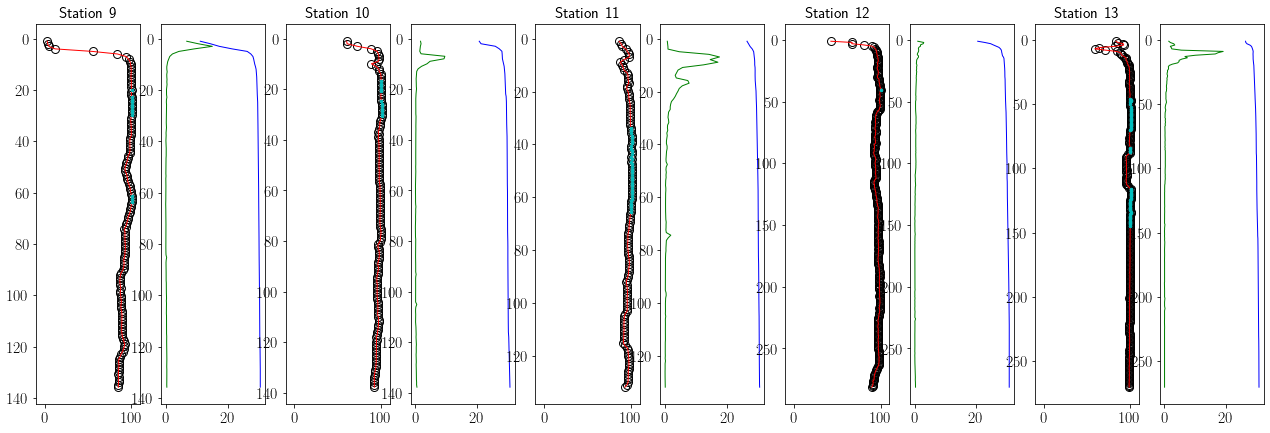

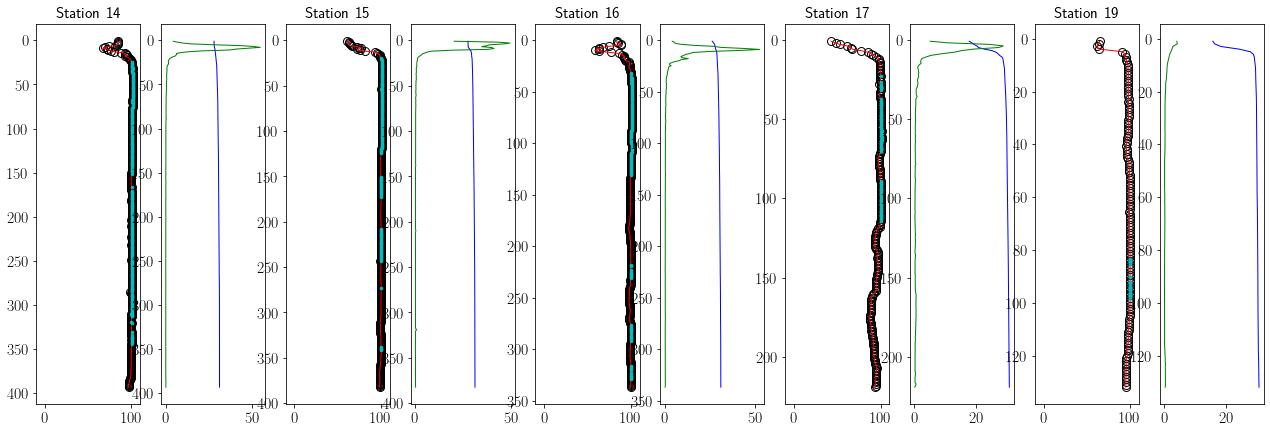

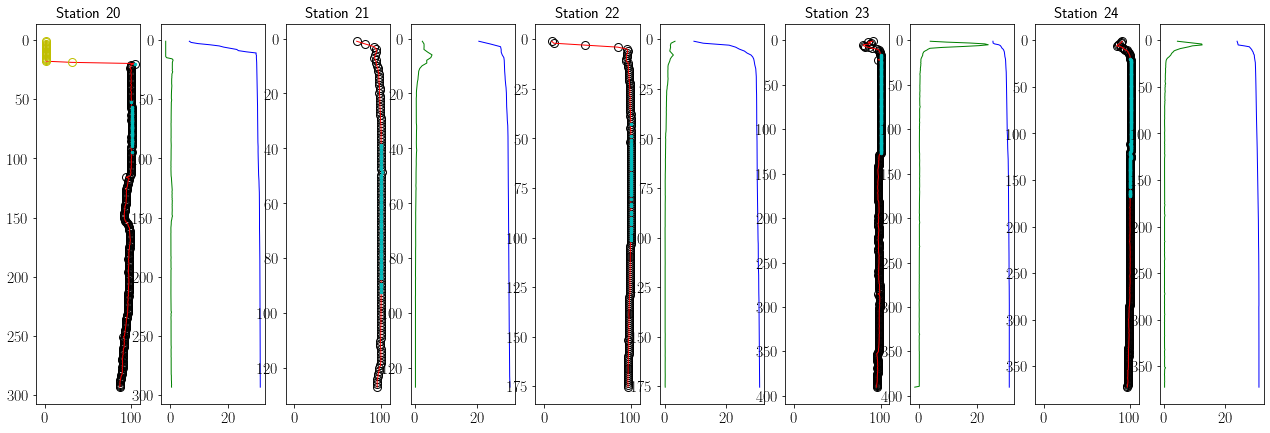

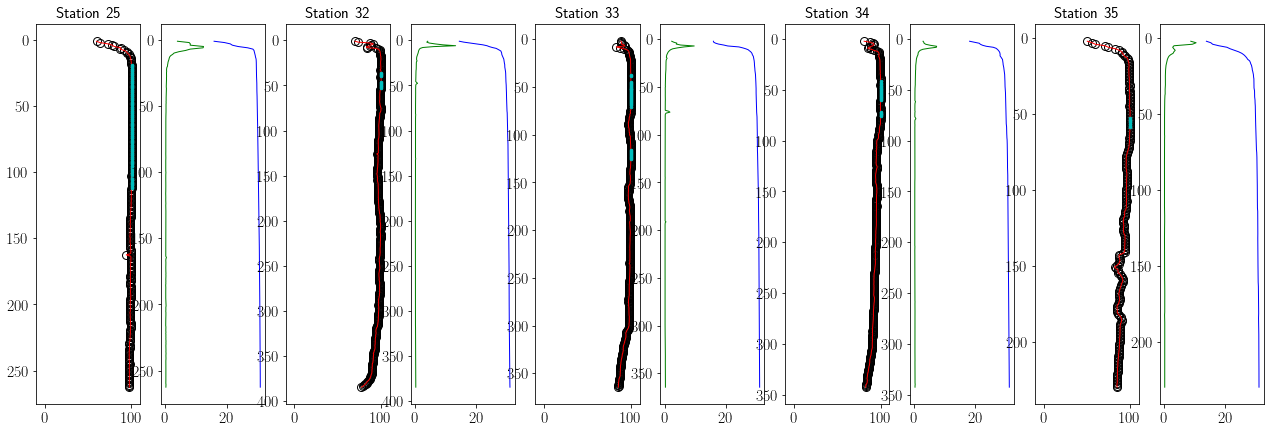

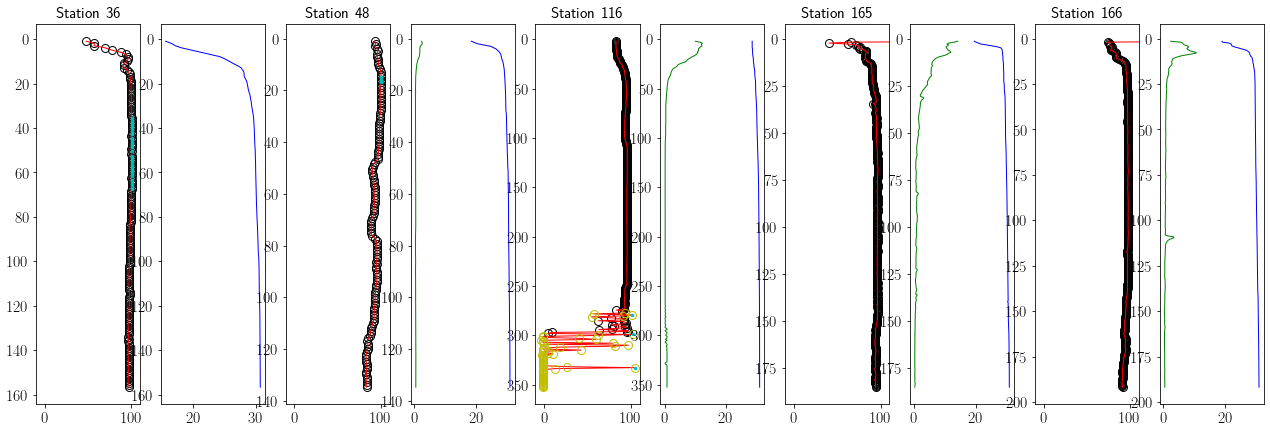

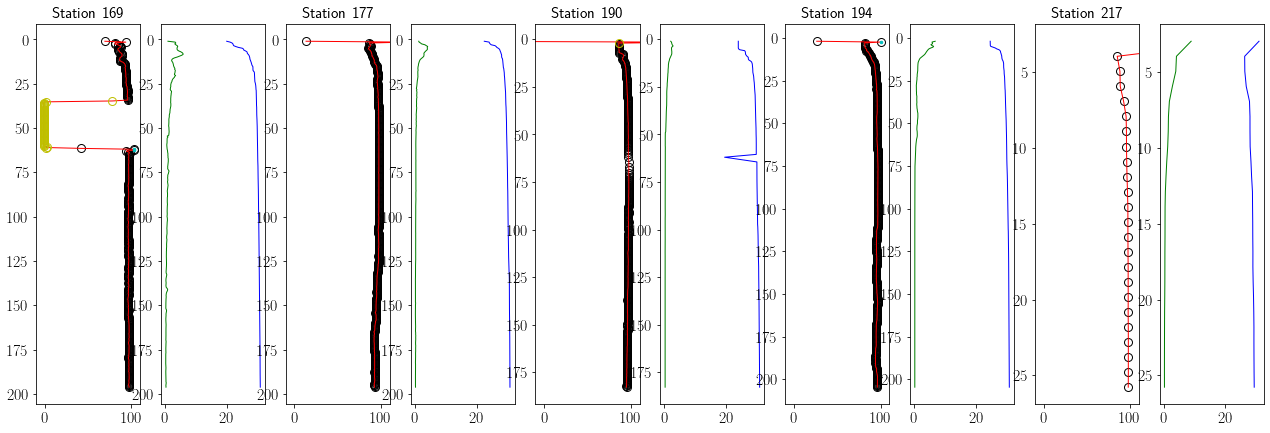

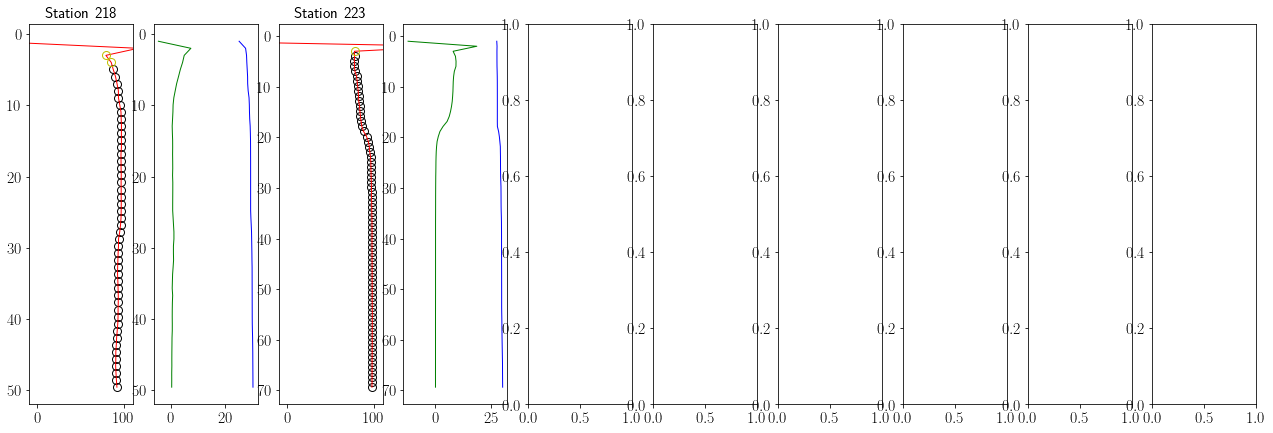

In [19]:
for ii, ista in enumerate(stalisthi):
    if ii%5==0:
        fig,ax=plt.subplots(1,10,figsize=(22,7))
    tdf=df.loc[df.StaID==ista].sort_values('Depth')
    iax=2*(ii%5)
    ias=2*(ii%5)+1
    ax[iax].plot(xmissQC(tdf['xmiss']),tdf['Depth'],'o',markeredgecolor='k',markerfacecolor='None' )
    ax[iax].plot(tdf['xmiss'],tdf['Depth'],'r-')
    ax[iax].plot(tdf.loc[tdf.xmiss>100,['xmiss']],tdf.loc[tdf.xmiss>100,['Depth']],'c.',ms=5)
    xm=tdf.xmiss.values.flatten()
    ax[iax].plot(xm[np.isnan(xmissQC(xm))],tdf.loc[np.isnan(xmissQC(xm)),['Depth']],'o',markeredgecolor='y',markerfacecolor='None' )
    ax[iax].invert_yaxis()
    ax[iax].set_title(f'Station {ista}')
    ax[ias].plot(tdf['sal00'],tdf['Depth'],'b-')
    ax[ias].plot(tdf['wetStar'],tdf['Depth'],'g-')
    ax[ias].invert_yaxis()
    ax[iax].set_xlim(-10,110)
    x=tdf['xmiss'].values
    noderiv=(x[1:]-x[:-1])==0
    if np.sum(noderiv)>0:
        print(f'{ista} Consts?: {np.sum(noderiv)}')
print('Profiles with >100 values')
print('Station 160 Mode:',sst.mode(df.loc[df.StaID==169,['xmiss']].values))

##### Values > 100 look in line with surrounding values; include them

In [20]:
xlo=session.query(CTDProfTBL.CTDStationTBLID.label('StaID')).filter(and_(
                    CTDProfTBL.xmiss<=0,
                    CTDProfTBL.CTDStationTBLID!=321
    )).group_by(CTDProfTBL.CTDStationTBLID).subquery()
xht=session.query(CTDProfTBL.CTDStationTBLID.label('StaID'),
                     CTDProfTBL.prSM,
                     CTDProfTBL.convertedDepth.label('Depth'),
                     CTDProfTBL.xmiss,
                     CTDProfTBL.wetStar,
                     CTDProfTBL.sal00).select_from(CTDProfTBL).join(xlo,xlo.c.StaID==CTDProfTBL.CTDStationTBLID)
df=pd.read_sql_query(xht.statement, engine)
df

,StaID,prSM,Depth,xmiss,wetStar,sal00
0,106,1.0,0.991493,-1.2850,-0.7229,28.1989
1,106,2.0,1.982980,-1.2850,-0.7229,28.1971
2,106,3.0,2.974463,-1.2850,-0.7229,28.1995
3,106,4.0,3.965942,-1.2850,-0.7229,28.1957
4,106,5.0,4.957415,-1.2850,-0.7229,28.1992
...,...,...,...,...,...,...
12000,446,148.0,146.688660,74.9241,0.5160,30.1953
12001,446,149.0,147.679442,73.0421,0.4781,30.1898
12002,446,150.0,148.670219,65.4197,0.5099,30.2147
12003,446,151.0,149.660992,59.1854,0.5036,30.2327


In [21]:
stalistlo=np.unique(df['StaID'])
print(len(stalistlo), 'stations have transmissivity values <= 0')

40 stations have transmissivity values <= 0


106 Consts?: 6
115 Consts?: 48
116 Consts?: 29
124 Consts?: 10
125 Consts?: 11
141 Consts?: 2
163 Consts?: 2
169 Consts?: 49
170 Consts?: 1
179 Consts?: 1
189 Consts?: 1
190 Consts?: 5
204 Consts?: 104
205 Consts?: 64
207 Consts?: 51
213 Consts?: 47
224 Consts?: 12
231 Consts?: 100
234 Consts?: 6
242 Consts?: 92
250 Consts?: 7
253 Consts?: 17
255 Consts?: 34
256 Consts?: 112
257 Consts?: 96
265 Consts?: 19
274 Consts?: 11
293 Consts?: 2
309 Consts?: 4
310 Consts?: 2
349 Consts?: 31
446 Consts?: 56
Profiles with <=0 values
Station 160 Mode: ModeResult(mode=array([[-1.285]]), count=array([[50]]))


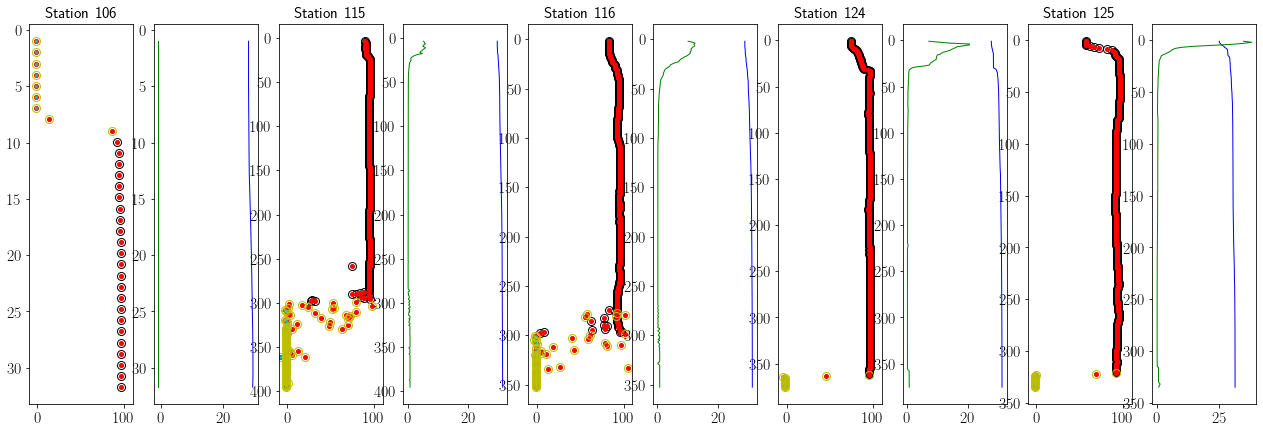

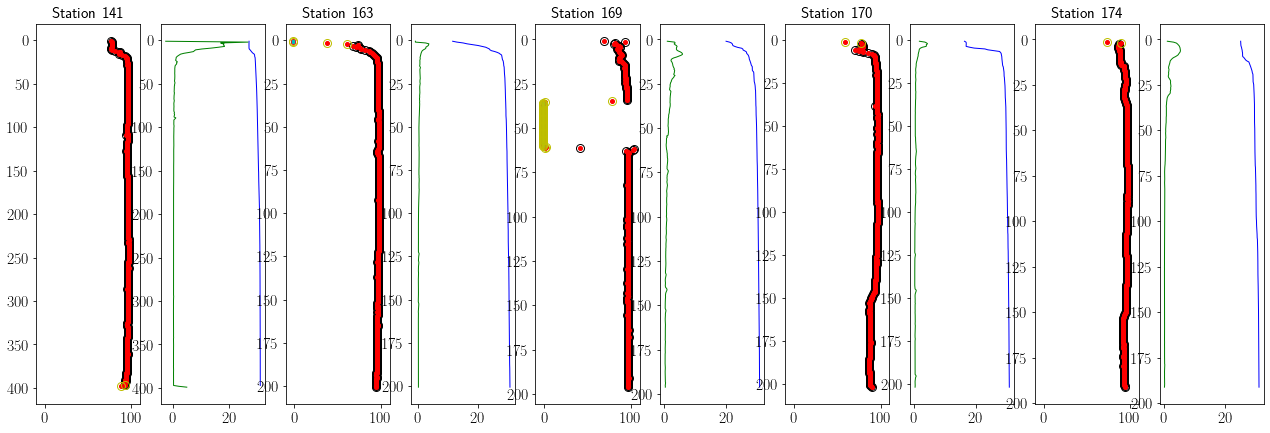

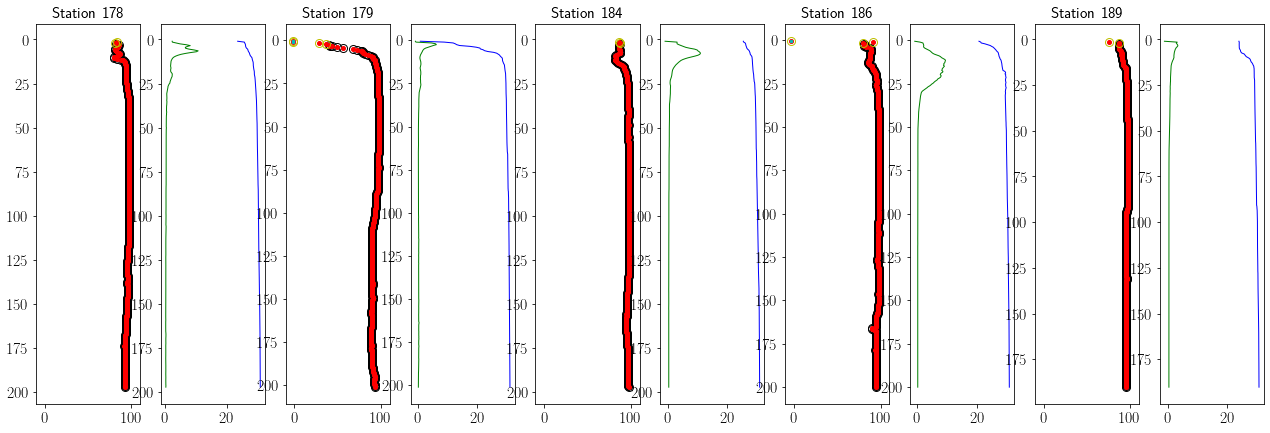

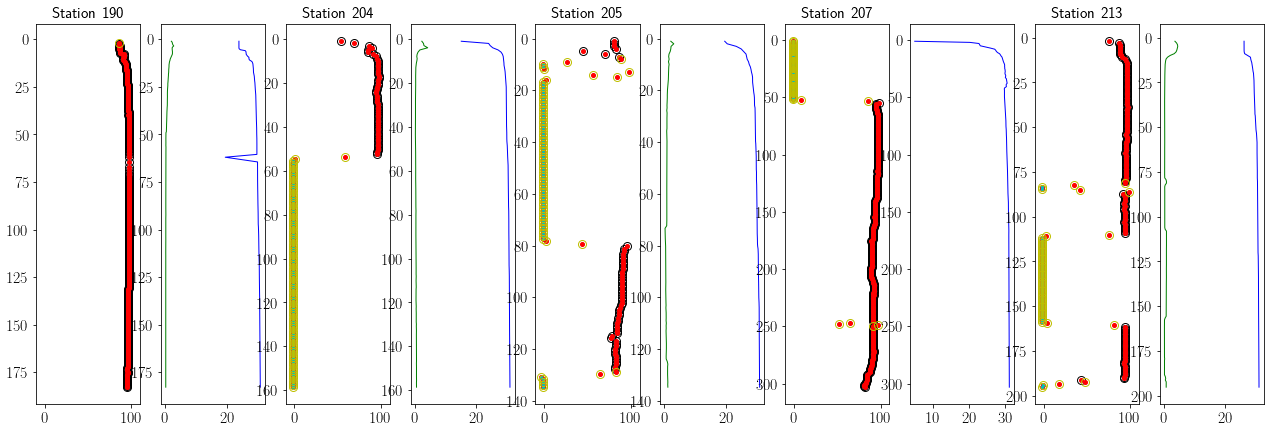

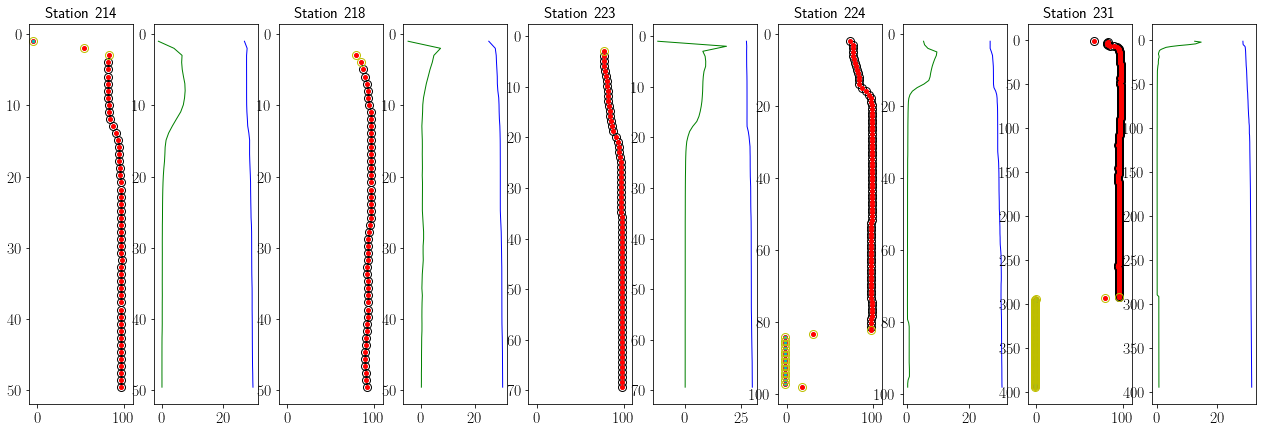

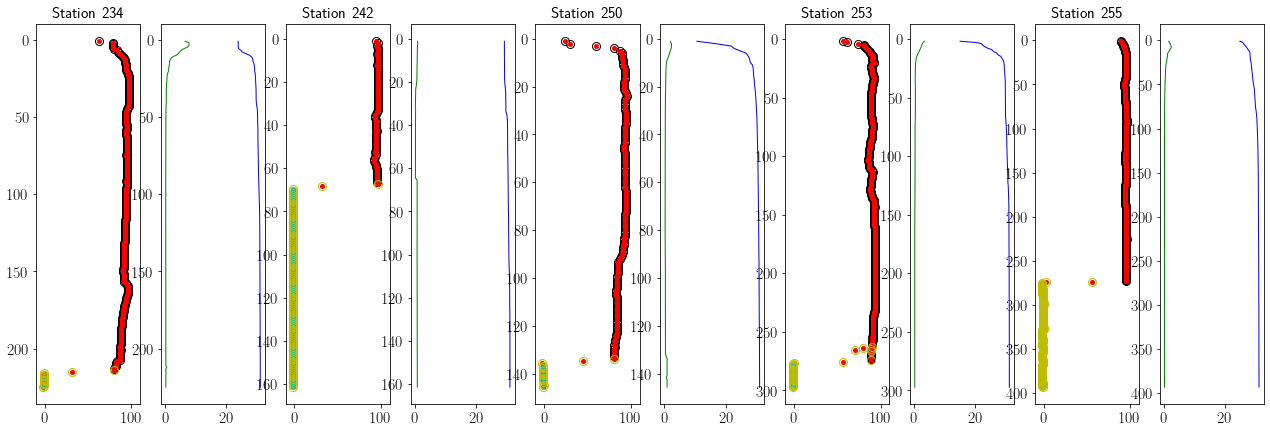

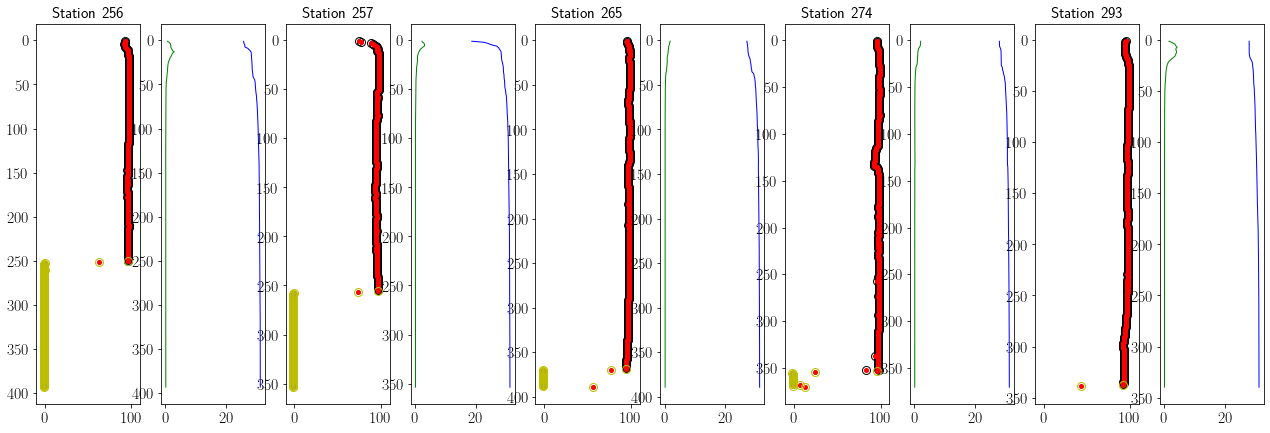

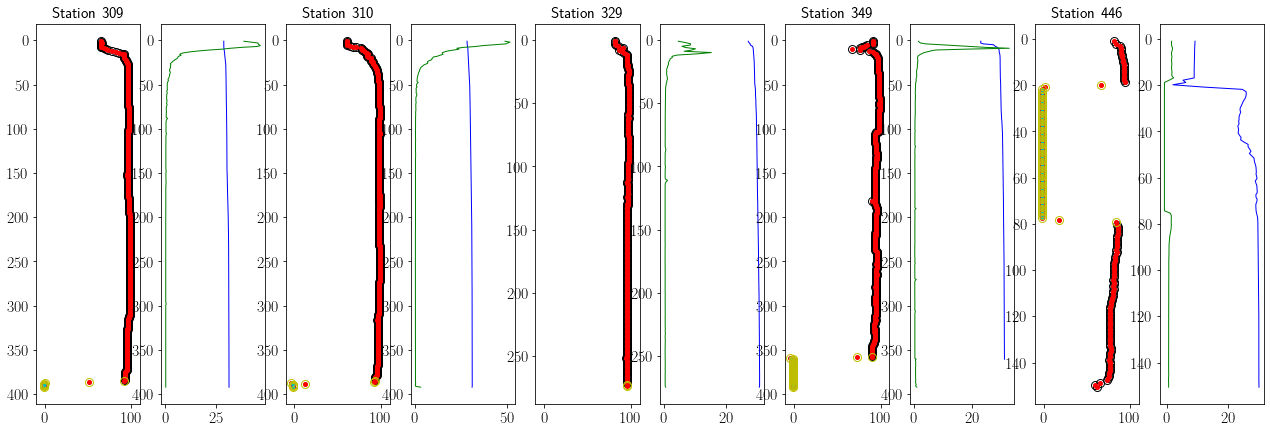

In [22]:
for ii, ista in enumerate(stalistlo):
    if ii%5==0:
        fig,ax=plt.subplots(1,10,figsize=(22,7))
    tdf=df.loc[df.StaID==ista].sort_values('Depth')
    iax=2*(ii%5)
    ias=2*(ii%5)+1
    ax[iax].plot(xmissQC(tdf['xmiss']),tdf['Depth'],'o',markeredgecolor='k',markerfacecolor='None' )
    ax[iax].plot(tdf['xmiss'],tdf['Depth'],'r.')
    ax[iax].plot(tdf.loc[tdf.xmiss<=0,['xmiss']],tdf.loc[tdf.xmiss<=0,['Depth']],'c.',ms=5)
    xm=tdf.xmiss.values.flatten()
    ax[iax].plot(xm[np.isnan(xmissQC(xm))],tdf.loc[np.isnan(xmissQC(xm)),['Depth']],'o',markeredgecolor='y',markerfacecolor='None' )
    ax[iax].invert_yaxis()
    ax[iax].set_title(f'Station {ista}')
    ax[ias].plot(tdf['sal00'],tdf['Depth'],'b-')
    ax[ias].plot(tdf['wetStar'],tdf['Depth'],'g-')
    ax[ias].invert_yaxis()
    ax[iax].set_xlim(-10,110)
    x=tdf['xmiss'].values
    noderiv=(x[1:]-x[:-1])==0
    if np.sum(noderiv)>0:
        print(f'{ista} Consts?: {np.sum(noderiv)}')

print('Profiles with <=0 values')
print('Station 160 Mode:',sst.mode(df.loc[df.StaID==169,['xmiss']].values))

##### show same profiles with only <=0 excluded:

In [23]:
xht=session.query(CTDProfTBL.CTDStationTBLID.label('StaID'),
                     CTDProfTBL.prSM,
                     CTDProfTBL.convertedDepth.label('Depth'),
                     CTDProfTBL.xmiss,CTDProfTBL.sal00,CTDProfTBL.t090C,CTDProfTBL.par,CTDProfTBL.UsePAR,
                     CTDProfTBL.wetStar).filter(and_(
                     CTDProfTBL.CTDStationTBLID!=321,
                     CTDProfTBL.xmiss==CTDProfTBL.xmiss))
df=pd.read_sql_query(xht.statement, engine)
df

,StaID,prSM,Depth,xmiss,sal00,t090C,par,UsePAR,wetStar
0,1,1.0,0.991493,79.3714,24.8197,8.7769,127.4400,True,14.0380
1,1,2.0,1.982980,78.5644,26.6071,8.7149,83.9590,True,19.5129
2,1,3.0,2.974463,82.0421,27.9831,8.6198,56.3430,True,22.1860
3,1,4.0,3.965942,83.4420,28.2416,8.5194,37.7110,True,17.0891
4,1,5.0,4.957415,86.1050,28.3202,8.4183,26.3400,True,17.7157
...,...,...,...,...,...,...,...,...,...
125474,517,225.0,222.964890,78.3905,30.9278,9.4343,3.5885,False,0.2098
125475,517,226.0,223.955304,78.0550,30.9308,9.4346,3.5725,False,0.2175
125476,517,227.0,224.945713,77.2890,30.9347,9.4336,3.6689,False,0.2218
125477,517,228.0,225.936118,76.3889,30.9354,9.4333,3.6932,False,0.2218


#### ID stations with constant sections:

In [52]:
stalistconst=list()
for ii, ista in enumerate(allStas):
    tdf=df.loc[df.StaID==ista].sort_values('Depth')
    xm=tdf['xmiss'].values.flatten()
    if hasconst(xm):
        stalistconst.append(tdf.StaID.values[0])
print(f'{len(stalistconst)} stations with const sections:\n',stalistconst)

26 stations with const sections:
 [18, 20, 106, 115, 116, 124, 125, 169, 204, 205, 207, 213, 224, 231, 234, 242, 250, 253, 255, 256, 257, 265, 274, 309, 349, 446]


Profiles with constant sections, len>4


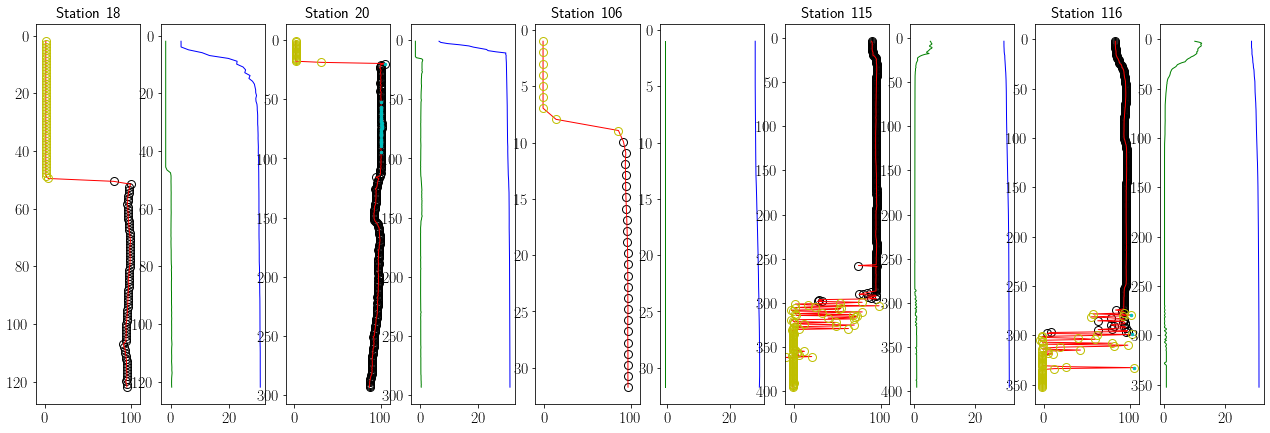

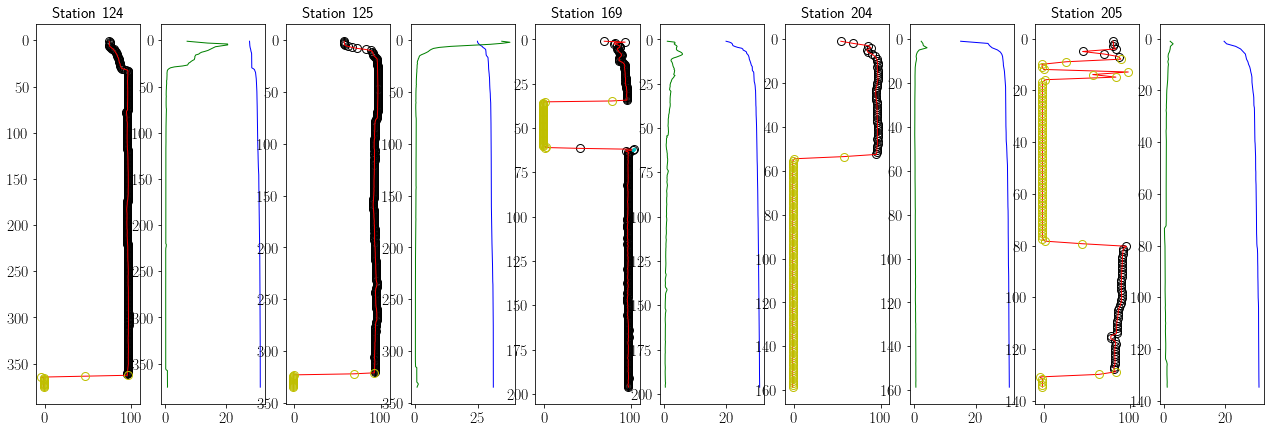

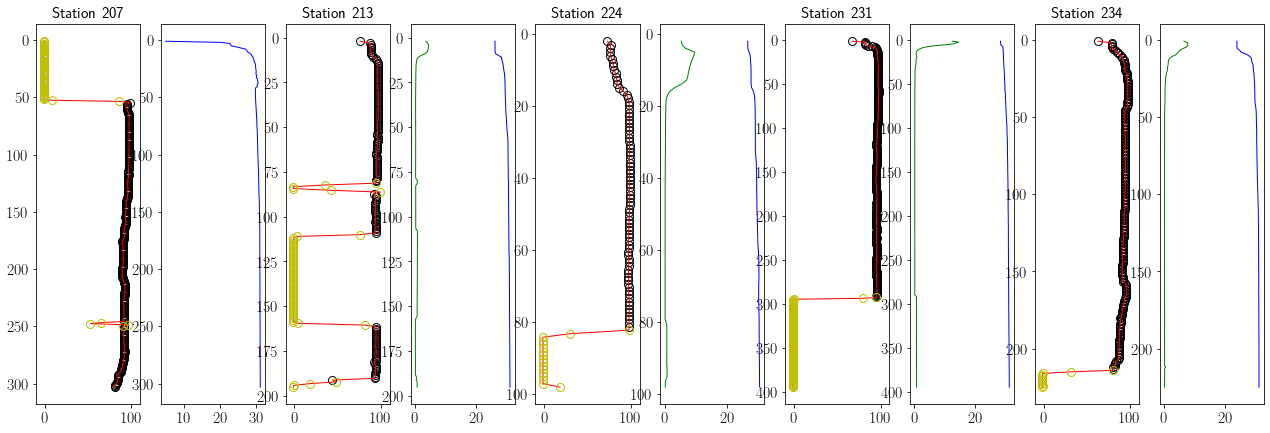

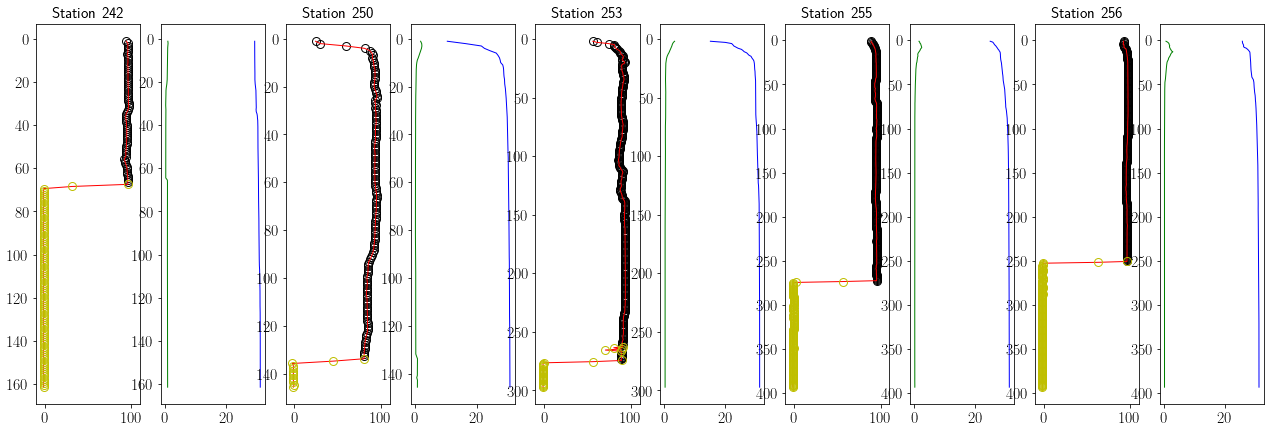

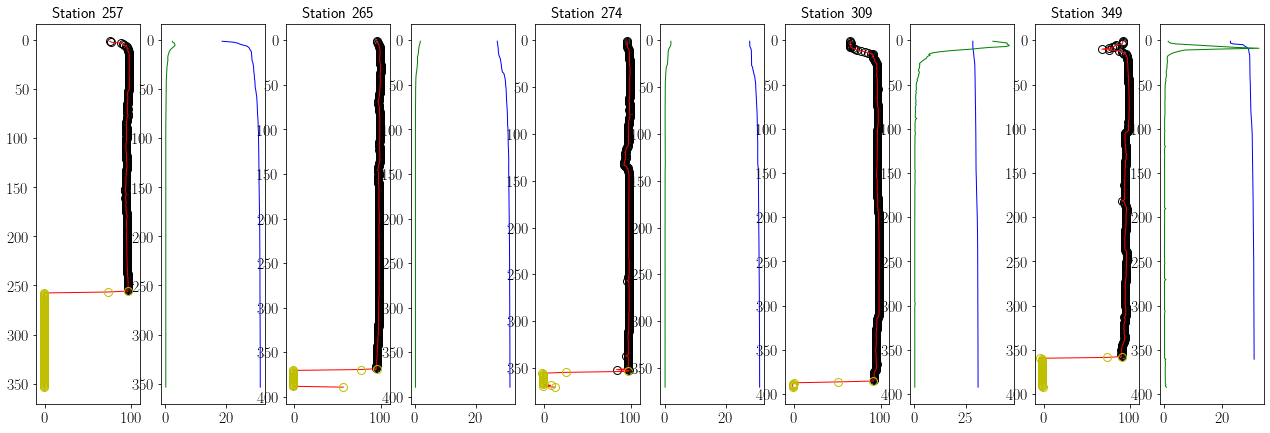

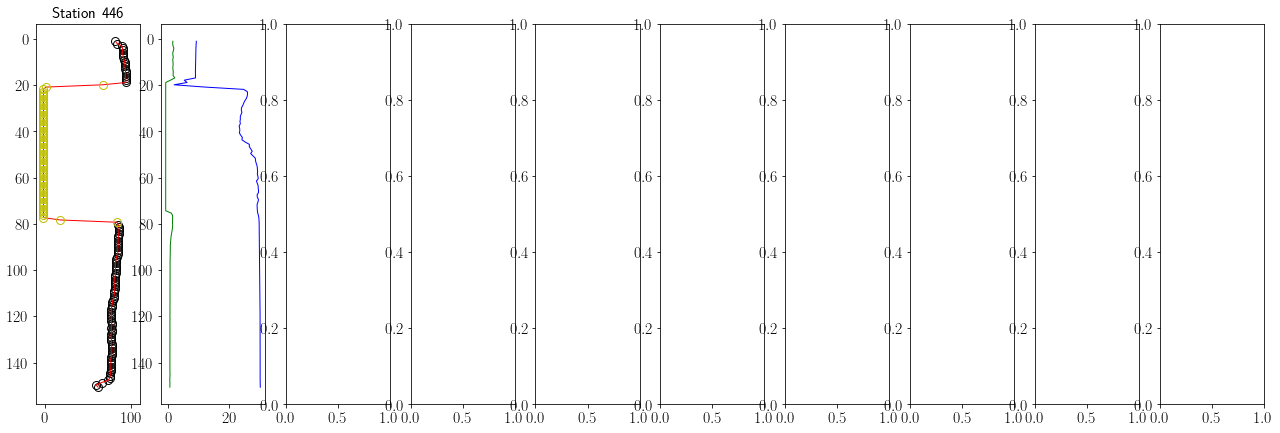

In [53]:
for ii, ista in enumerate(stalistconst):
    if ii%5==0:
        fig,ax=plt.subplots(1,10,figsize=(22,7))
    tdf=df.loc[df.StaID==ista].sort_values('Depth')
    iax=2*(ii%5)
    ias=2*(ii%5)+1
    ax[iax].plot(xmissQC(tdf['xmiss']),tdf['Depth'],'o',markeredgecolor='k',markerfacecolor='None' )
    ax[iax].plot(tdf['xmiss'],tdf['Depth'],'r-')
    ax[iax].plot(tdf.loc[tdf.xmiss>100,['xmiss']],tdf.loc[tdf.xmiss>100,['Depth']],'c.',ms=5)
    xm=tdf.xmiss.values.flatten()
    ax[iax].plot(xm[np.isnan(xmissQC(xm))],tdf.loc[np.isnan(xmissQC(xm)),['Depth']],'o',markeredgecolor='y',markerfacecolor='None' )
    ax[iax].invert_yaxis()
    ax[iax].set_title(f'Station {ista}')
    ax[ias].plot(tdf['sal00'],tdf['Depth'],'b-')
    ax[ias].plot(tdf['wetStar'],tdf['Depth'],'g-')
    ax[ias].invert_yaxis()
    ax[iax].set_xlim(-10,110)
print('Profiles with constant sections, len>4')

In [24]:
## all other stations:
stalist=list(set(allStas)-set(stalisthi)-set(stalistlo))

In [25]:
print(f'Remaining Stations: {len(stalist)}')

Remaining Stations: 430


15 Consts?: 2
20 Consts?: 17
24 Consts?: 3
32 Consts?: 1
116 Consts?: 29
169 Consts?: 49
177 Consts?: 1
190 Consts?: 5
194 Consts?: 1
Unflagged profiles


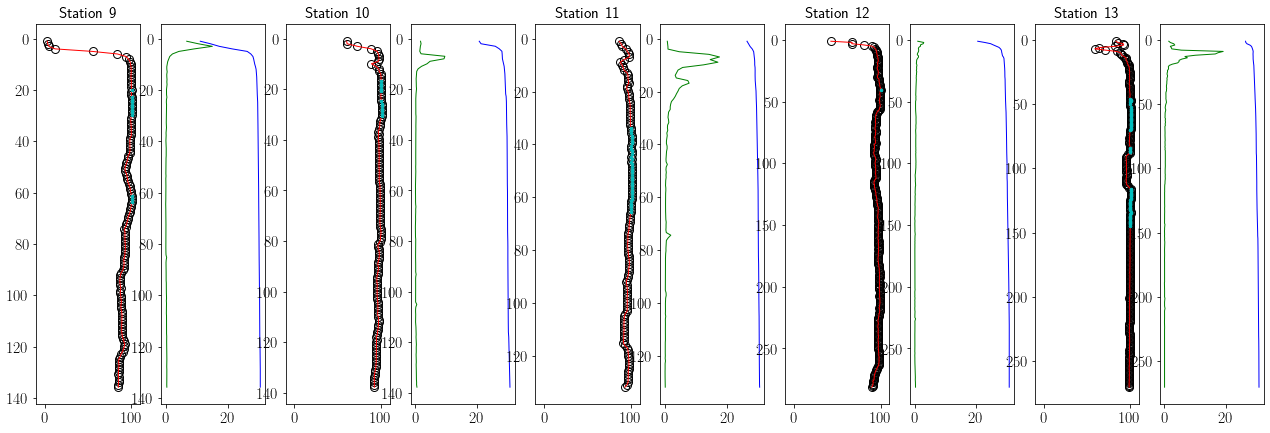

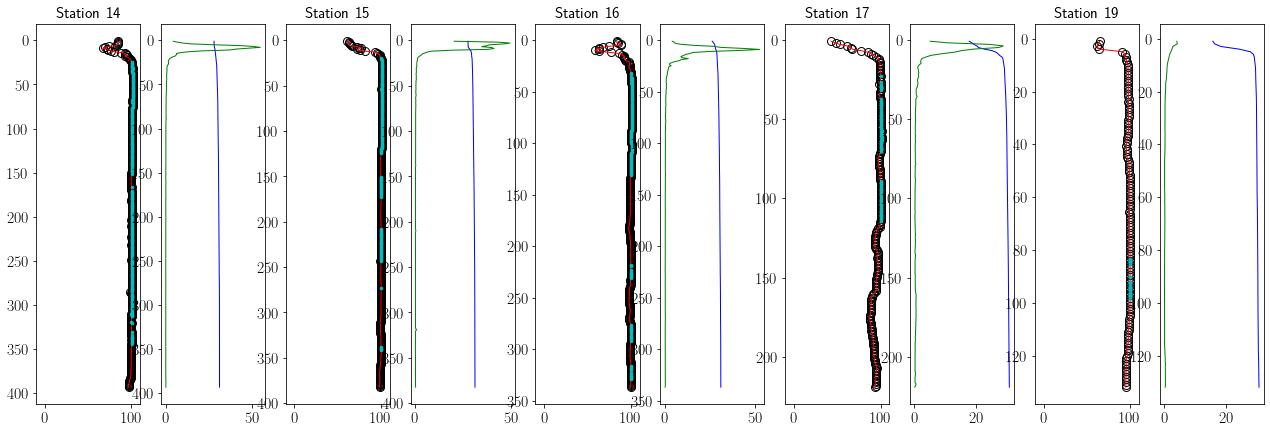

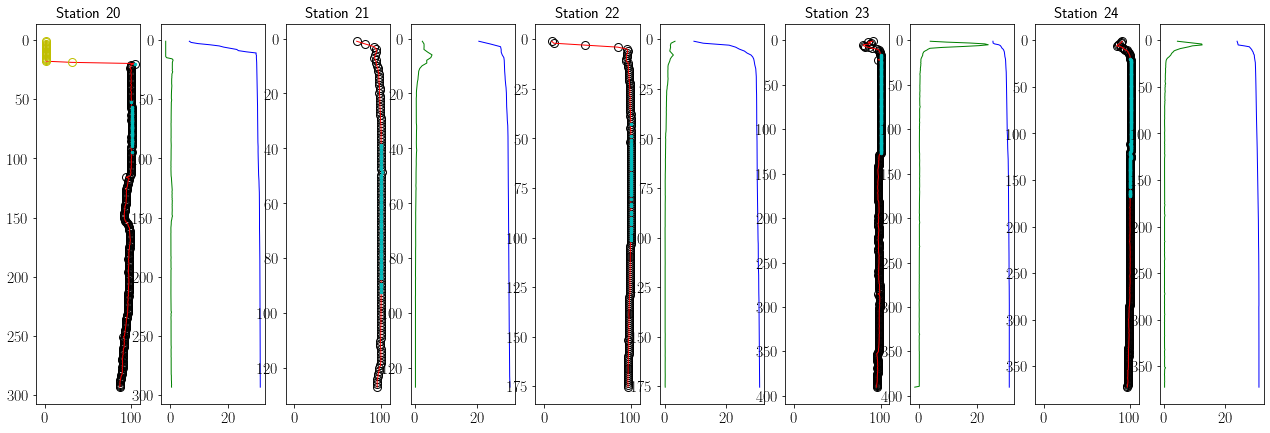

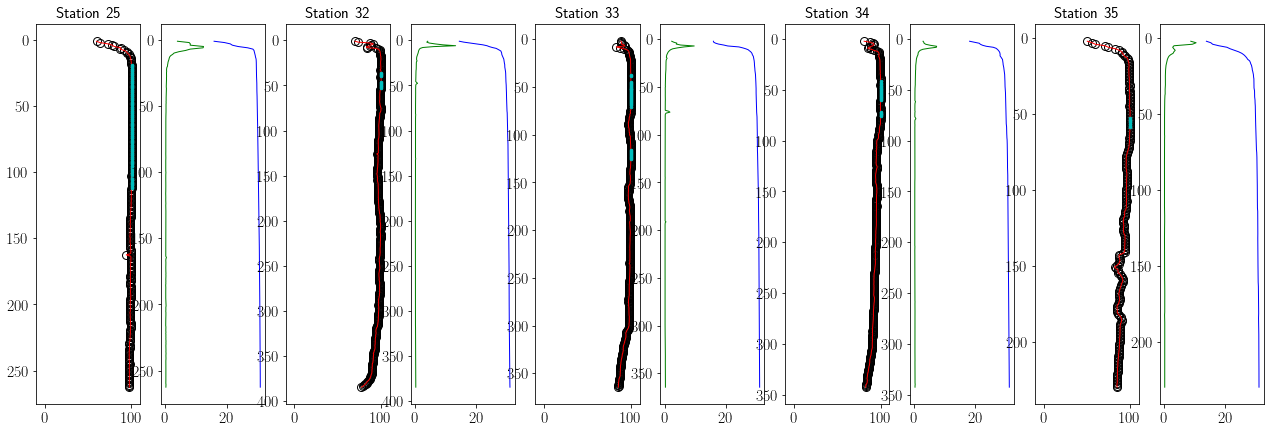

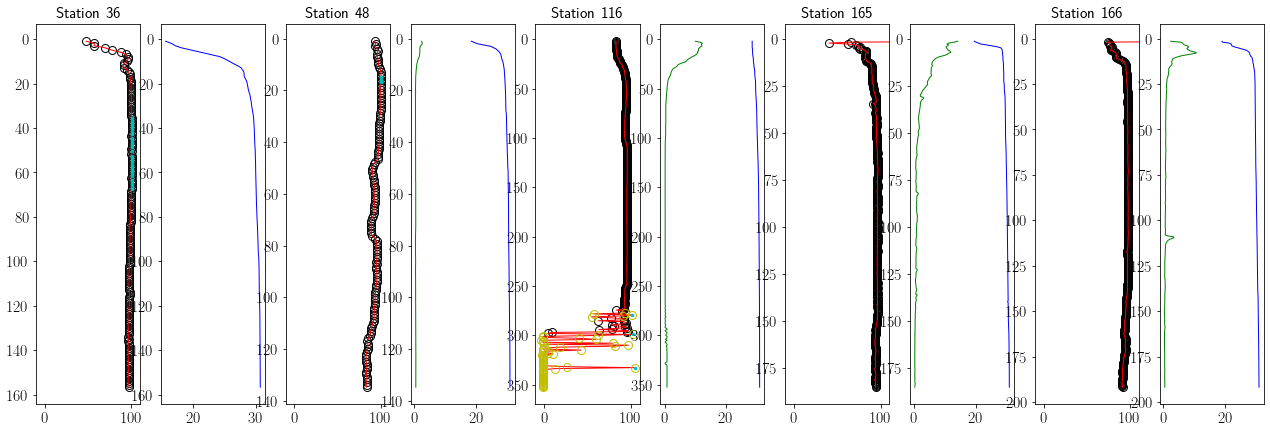

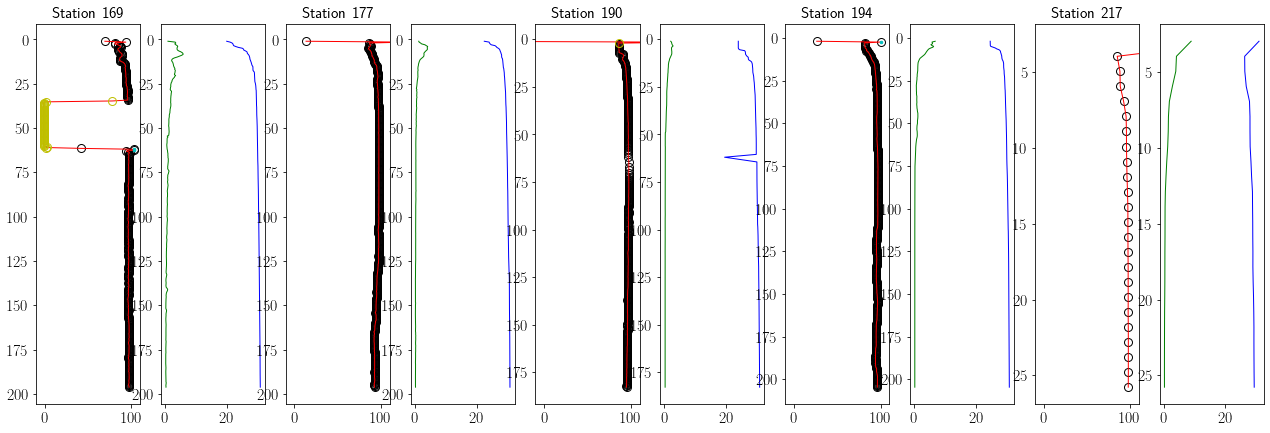

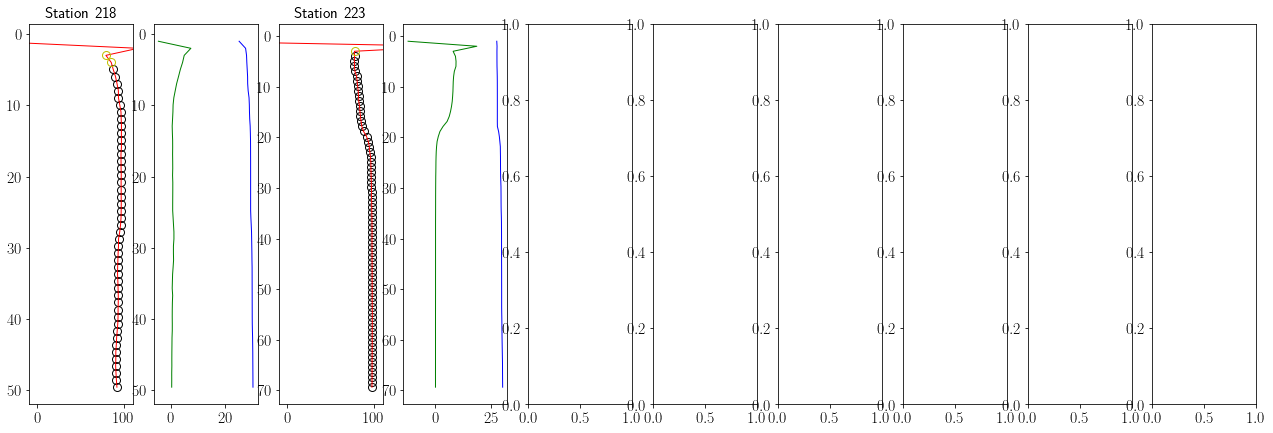

In [26]:
for ii, ista in enumerate(stalisthi):
    if ii%5==0:
        fig,ax=plt.subplots(1,10,figsize=(22,7))
    tdf=df.loc[df.StaID==ista].sort_values('Depth')
    iax=2*(ii%5)
    ias=2*(ii%5)+1
    ax[iax].plot(xmissQC(tdf['xmiss']),tdf['Depth'],'o',markeredgecolor='k',markerfacecolor='None' )
    ax[iax].plot(tdf['xmiss'],tdf['Depth'],'r-')
    ax[iax].plot(tdf.loc[tdf.xmiss>100,['xmiss']],tdf.loc[tdf.xmiss>100,['Depth']],'c.',ms=5)
    xm=tdf.xmiss.values.flatten()
    ax[iax].plot(xm[np.isnan(xmissQC(xm))],tdf.loc[np.isnan(xmissQC(xm)),['Depth']],'o',markeredgecolor='y',markerfacecolor='None' )
    ax[iax].invert_yaxis()
    ax[iax].set_title(f'Station {ista}')
    ax[ias].plot(tdf['sal00'],tdf['Depth'],'b-')
    ax[ias].plot(tdf['wetStar'],tdf['Depth'],'g-')
    ax[ias].invert_yaxis()
    ax[iax].set_xlim(-10,110)
    x=tdf['xmiss'].values
    noderiv=(x[1:]-x[:-1])==0
    if np.sum(noderiv)>0:
        print(f'{ista} Consts?: {np.sum(noderiv)}')
print('Unflagged profiles')

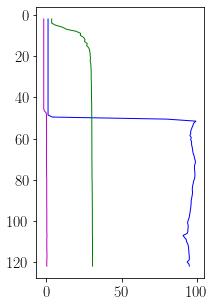

In [27]:
fig,ax=plt.subplots(1,1,figsize=(3,5))
ax.plot(df.loc[df.StaID==18,['xmiss']],df.loc[df.StaID==18,['Depth']],'b-')
ax.plot(df.loc[df.StaID==18,['wetStar']],df.loc[df.StaID==18,['Depth']],'m-')
ax.plot(df.loc[df.StaID==18,['sal00']],df.loc[df.StaID==18,['Depth']],'g-')
ax.invert_yaxis()

In [28]:
df.loc[df.StaID==18]

,StaID,prSM,Depth,xmiss,sal00,t090C,par,UsePAR,wetStar
4010,18,2.0,1.982980,1.2043,3.5870,10.8507,5.0604,False,-1.6474
4011,18,3.0,2.974463,1.2043,3.5992,10.8445,2.5367,False,-1.6474
4012,18,4.0,3.965942,1.2043,3.6009,10.8249,2.5434,False,-1.6474
4013,18,5.0,4.957415,1.2043,6.1453,10.9524,2.5655,False,-1.6474
4014,18,6.0,5.948884,1.2043,10.7795,11.2212,2.5549,False,-1.6474
...,...,...,...,...,...,...,...,...,...
4127,18,119.0,117.953890,94.7313,30.6405,8.7478,2.5338,False,0.4430
4128,18,120.0,118.944811,94.6380,30.6430,8.7488,2.5396,False,0.3760
4129,18,121.0,119.935728,93.2413,30.6451,8.7492,2.5336,False,0.3637
4130,18,122.0,120.926639,94.5067,30.6474,8.7493,2.5304,False,0.3607
